## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [26]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!pip install wandb
import wandb
wandb.login()

In [0]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'


In [0]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import cv2
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)



# ImageNet Subset


In [0]:
!git clone https://github.com/thunderInfy/imagenet-5-categories


In [0]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))


In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [76]:

X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)


(1250, 128, 128, 3) (1250,)



(250, 128, 128, 3) (250,)


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [0]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_enc))

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(256, activation="relu"),
		UnitNormLayer()
	])

	return projector

## Adam with lr decay function

### Training the encoder and the projector

In [0]:
#SGD with lr decay function


decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.RMSprop(lr_decayed_fn)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.254
Epoch: 10 Loss: 0.141
Epoch: 20 Loss: 0.106
Epoch: 30 Loss: 0.064
Epoch: 40 Loss: 0.015
Epoch: 50 Loss: 0.011



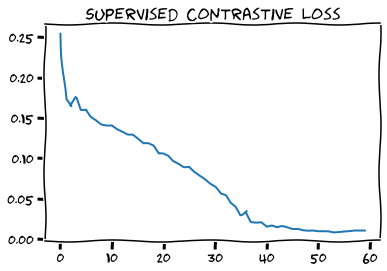

[<tf.Tensor: shape=(), dtype=float32, numpy=0.25418776>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17280793>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16400596>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17572327>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16005397>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16096541>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15231578>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14813322>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14301175>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1414721>, <tf.Tensor: shape=(), dtype=float32, numpy=0.141219>, <tf.Tensor: shape=(), dtype=float32, numpy=0.136118>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13275762>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12889624>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12848012>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12312877>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11772348>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1176769

In [84]:
import time

wandb.init(project="scl", entity="authors",id='SCL_Adam_LRDECAY')
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()
print(train_loss_results)

### Training the Supervised Model





In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [0]:
from wandb.keras import WandbCallback


In [0]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [88]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer2,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=2,
	restore_best_weights=True, verbose=2)

wandb.init(project="scl", entity="authors", id='FSL_Adam_LRDECAY ')

start = time.time()
supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[WandbCallback(),es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/100
20/20 [==============================] - 3s 150ms/step - loss: 1.4039 - sparse_categorical_accuracy: 0.8736 - val_loss: 1.3597 - val_sparse_categorical_accuracy: 0.6280
Epoch 2/100
20/20 [==============================] - 2s 103ms/step - loss: 1.0171 - sparse_categorical_accuracy: 0.9848 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.6200
Epoch 3/100
20/20 [==============================] - 3s 161ms/step - loss: 0.7331 - sparse_categorical_accuracy: 0.9848 - val_loss: 1.0779 - val_sparse_categorical_accuracy: 0.6240
Epoch 00003: early stopping


## Adam with learning rate=1e-3

### Training the encoder and the projector

In [0]:
optimizer3=tf.keras.optimizers.Adam(learning_rate=1e-3)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer3.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.220
Epoch: 10 Loss: 0.103
Epoch: 20 Loss: 0.081
Epoch: 30 Loss: 0.037
Epoch: 40 Loss: 0.016
Epoch: 50 Loss: 0.012
Epoch: 60 Loss: 0.011
Epoch: 70 Loss: 0.011
Epoch: 80 Loss: 0.007
Epoch: 90 Loss: 0.006



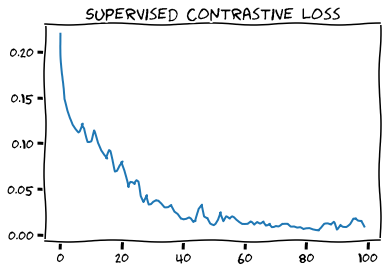

[<tf.Tensor: shape=(), dtype=float32, numpy=0.21988836>, <tf.Tensor: shape=(), dtype=float32, numpy=0.14853683>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13579017>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12744582>, <tf.Tensor: shape=(), dtype=float32, numpy=0.120279446>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11585663>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11240043>, <tf.Tensor: shape=(), dtype=float32, numpy=0.122045115>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11680545>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10179915>, <tf.Tensor: shape=(), dtype=float32, numpy=0.102698505>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11420488>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10046576>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09200291>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0869614>, <tf.Tensor: shape=(), dtype=float32, numpy=0.08287025>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09260927>, <tf.Tensor: shape=(), dtype=float32, numpy=0.

In [92]:
import time

wandb.init(project="scl", entity="authors",id='SCL_Adam_LR_0.001_100')
EPOCHS = 100
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()
print(train_loss_results)

### Training the Supervised Model


In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [94]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer2,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=2,
	restore_best_weights=True, verbose=2)

wandb.init(project="scl", entity="authors", id='FSL_Adam_LR_0.001')

start = time.time()
supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[WandbCallback(),es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/100
20/20 [==============================] - 3s 152ms/step - loss: 1.3128 - sparse_categorical_accuracy: 0.9088 - val_loss: 1.2464 - val_sparse_categorical_accuracy: 0.6280
Epoch 2/100
20/20 [==============================] - 2s 108ms/step - loss: 0.7306 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.0713 - val_sparse_categorical_accuracy: 0.6280
Epoch 3/100
20/20 [==============================] - 2s 117ms/step - loss: 0.4370 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.0296 - val_sparse_categorical_accuracy: 0.6320
Epoch 4/100
20/20 [==============================] - 2s 104ms/step - loss: 0.3023 - sparse_categorical_accuracy: 0.9808 - val_loss: 1.0341 - val_sparse_categorical_accuracy: 0.6400
Epoch 5/100
20/20 [==============================] - 2s 84ms/step - loss: 0.2333 - sparse_categorical_accuracy: 0.9808 - val_loss: 1.0522 - val_sparse_categorical_accuracy: 0.6400
Epoch 6/100
20/20 [==============================] - 2s 90ms/step - loss: 0.1927 - sparse_catego

# Adding augmentation

### Preparing dataset

In [0]:
#Random Augmentations

def aug(image, label):
  x=tf.image.random_brightness(image,max_delta=0)
  x=tf.image.random_contrast(x,lower=0.2, upper=1.8)
  x = tf.image.random_saturation(x, lower=0.2, upper=1.5)
  x = tf.image.random_hue(x, max_delta=0.4)
  x = tf.clip_by_value(x, 0, 1)

  return x, label

In [0]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_enc))

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
    .map(aug, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

### Training the encoder and decoder

In [0]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.243
Epoch: 10 Loss: 0.132
Epoch: 20 Loss: 0.094
Epoch: 30 Loss: 0.039
Epoch: 40 Loss: 0.006
Epoch: 50 Loss: 0.005



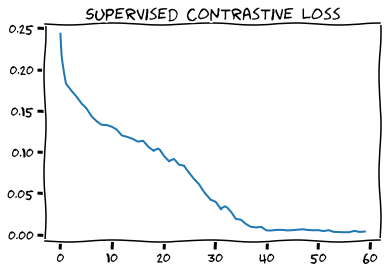

[<tf.Tensor: shape=(), dtype=float32, numpy=0.24336703>, <tf.Tensor: shape=(), dtype=float32, numpy=0.18270658>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17384906>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16619673>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15796715>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15217885>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1432936>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13781896>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13379517>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13375352>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13194692>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1285313>, <tf.Tensor: shape=(), dtype=float32, numpy=0.121216774>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11921774>, <tf.Tensor: shape=(), dtype=float32, numpy=0.116507426>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11282544>, <tf.Tensor: shape=(), dtype=float32, numpy=0.113572076>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1

In [100]:
import time

wandb.init(project="scl", entity="authors", id='SCL_Adam_LRDECAY_AUG')
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()
print(train_loss_results)

### Trainig Supervised model

In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [102]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer2,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=2,
	restore_best_weights=True, verbose=2)

wandb.init(project="scl", entity="authors", id='FSL_Adam_LRDECAY_AUG')

start = time.time()
supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[WandbCallback(),es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/100
20/20 [==============================] - 3s 164ms/step - loss: 1.3532 - sparse_categorical_accuracy: 0.6952 - val_loss: 1.1685 - val_sparse_categorical_accuracy: 0.6480
Epoch 2/100
20/20 [==============================] - 3s 142ms/step - loss: 0.9519 - sparse_categorical_accuracy: 0.7520 - val_loss: 1.0018 - val_sparse_categorical_accuracy: 0.6560
Epoch 3/100
20/20 [==============================] - 3s 127ms/step - loss: 0.8075 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.9555 - val_sparse_categorical_accuracy: 0.6480
Epoch 4/100
20/20 [==============================] - 3s 143ms/step - loss: 0.7606 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.9511 - val_sparse_categorical_accuracy: 0.6560
Epoch 00004: early stopping


# Saving Weights

In [0]:
encoder_r.save_weights("SCL_encoder_RMS.h5")

In [0]:
projector_z.save_weights("SCL_projector_RMS.h5")